In [2]:
import os
import torch
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quad_quad_tdc_bend
from phase_space_reconstruction.virtual.scans import run_quad_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.analysis import plot_scan_data, plot_predicted_screens
from phase_space_reconstruction.train import train_1d_scan
from bmadx.plot import plot_projections

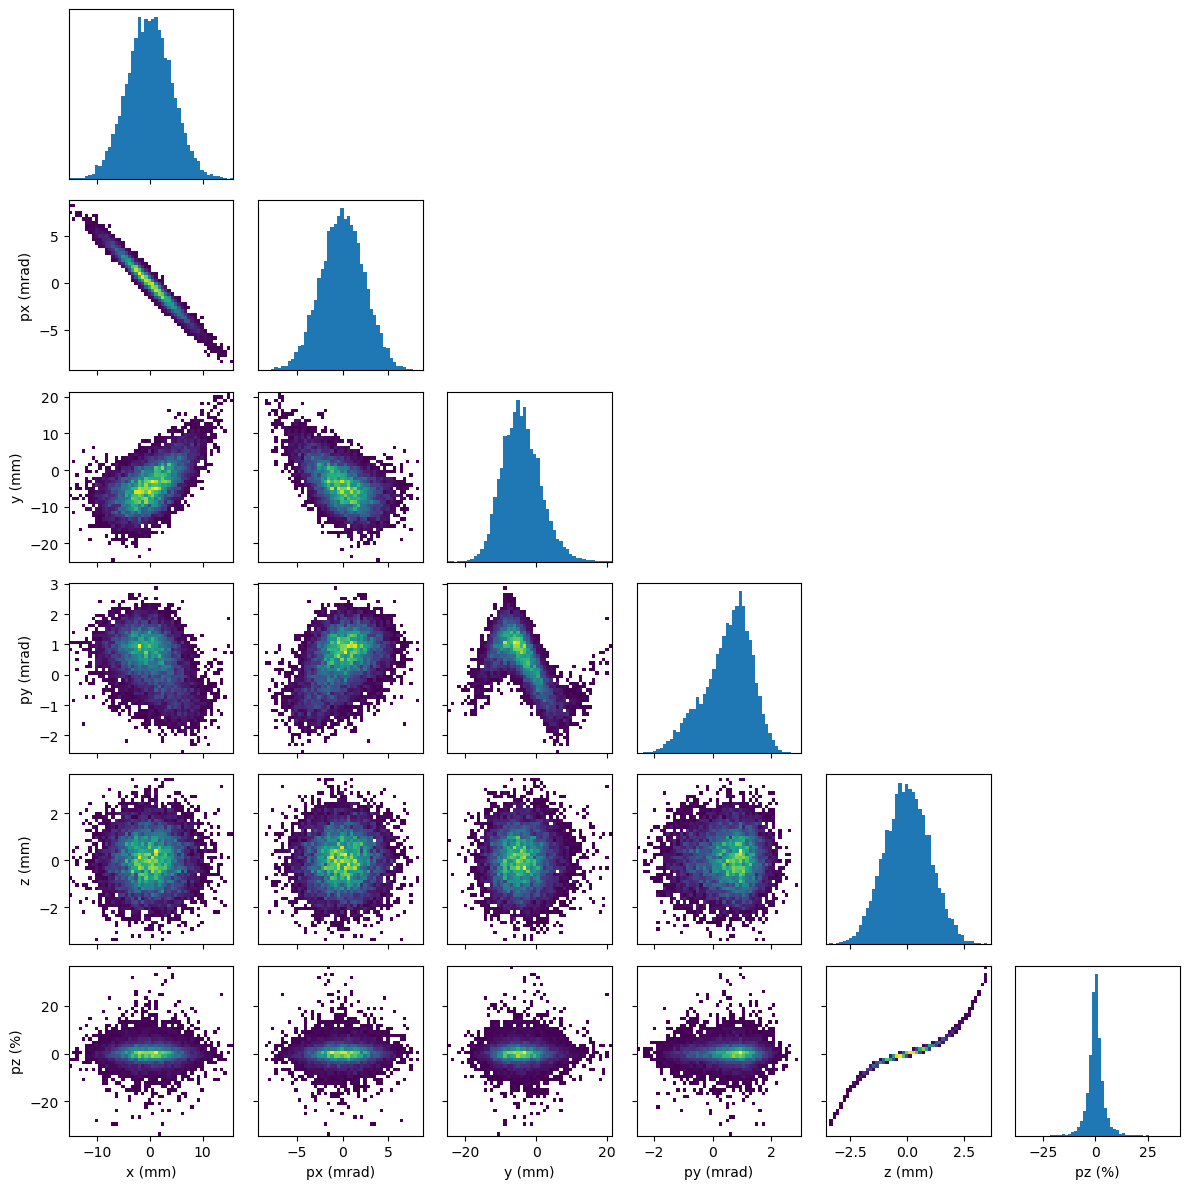

In [3]:
data_dir = 'data'

gt_beam = torch.load(os.path.join(data_dir, 'gt_beam.pt'))
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()

In [10]:
# diagnostic beamline:
p0c = 43.36e6
lattice = quad_quad_tdc_bend(p0c)
lattice.elements[4].VOLTAGE.data = torch.tensor(0)

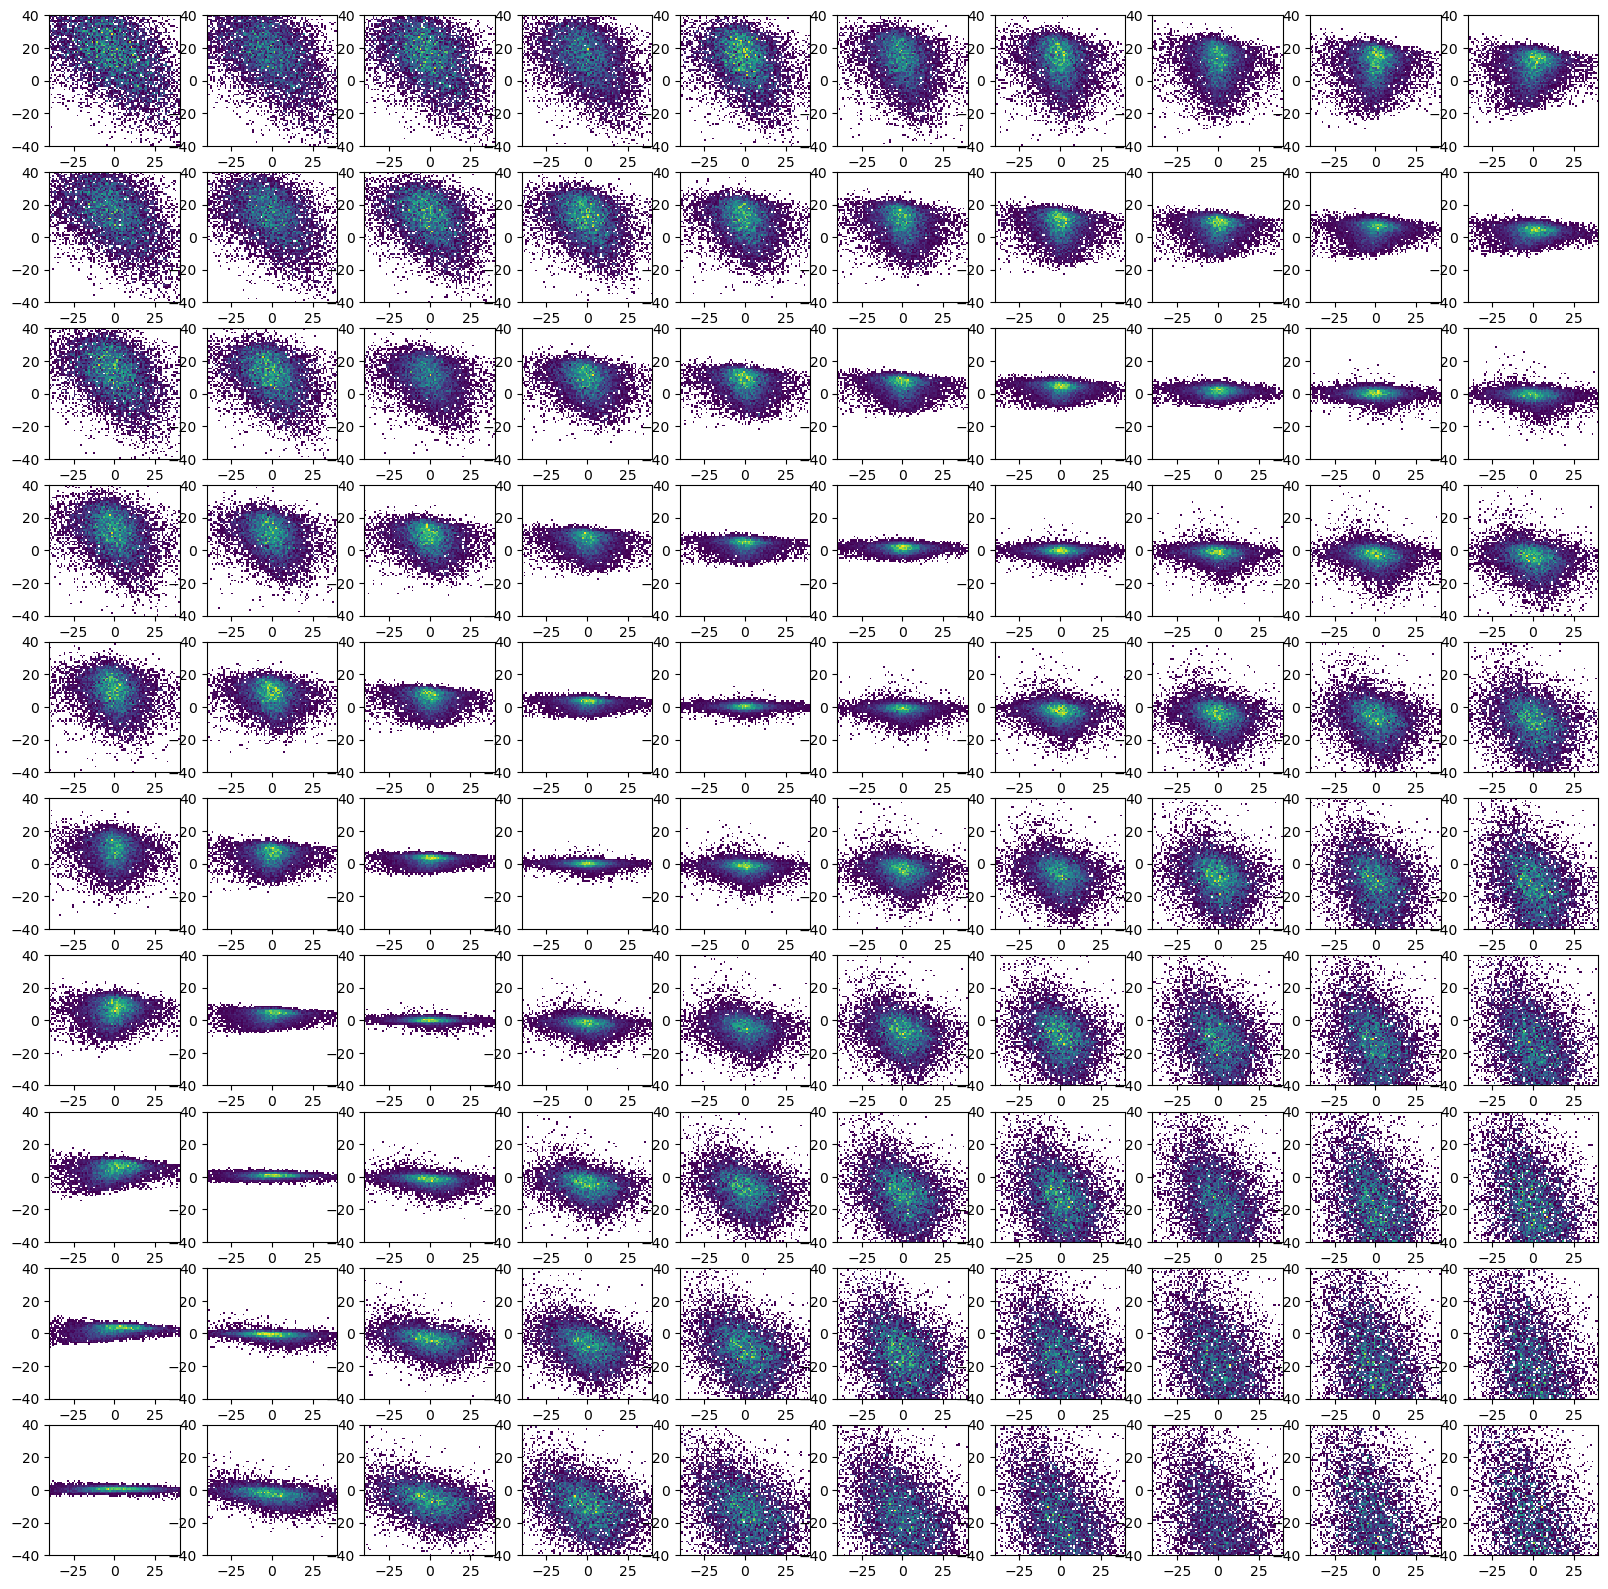

In [20]:
ks1 = torch.linspace(-10, 10, 10)
ks2 = torch.linspace(-10, 10, 10)

fig, ax = plt.subplots(len(ks2),len(ks1), figsize=(20,20))
mycmap = plt.get_cmap('viridis') # viridis plasma inferno magma and _r versions
mycmap.set_under(color='white') # map 0 to this color
myvmin = 1 # something tiny

for i in range(len(ks1)):
    lattice.elements[0].K1.data = ks1[i]
    for j in range(len(ks2)): 
        lattice.elements[2].K1.data = ks2[j]
        beam_out = lattice(gt_beam)
        # Bin particles
        ax[i, j].hist2d(x=1000*beam_out.x.numpy(), y=1000*beam_out.y.numpy(),  bins=[80,80], range=[[-40,40],[-40,40]] ,cmap=mycmap, vmin=myvmin)
        ax[i, j].set_aspect('equal')

    

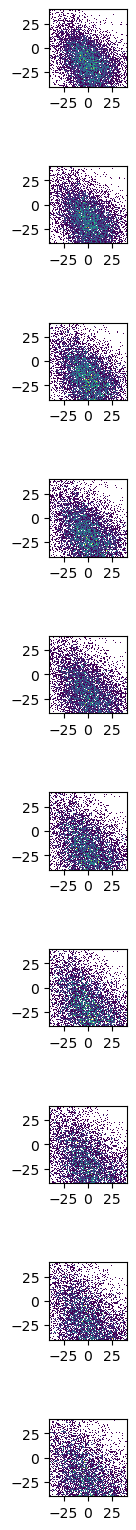

In [24]:
ks1 = torch.linspace(10, 20, 10)
lattice.elements[2].K1.data = torch.tensor(0)

fig, ax = plt.subplots(len(ks1),1, figsize=(1,20))
mycmap = plt.get_cmap('viridis') # viridis plasma inferno magma and _r versions
mycmap.set_under(color='white') # map 0 to this color
myvmin = 1 # something tiny

for i in range(len(ks1)):
    lattice.elements[0].K1.data = ks1[i]
    beam_out = lattice(gt_beam)
    # Bin particles
    ax[i].hist2d(x=1000*beam_out.x.numpy(), y=1000*beam_out.y.numpy(),  bins=[80,80], range=[[-40,40],[-40,40]] ,cmap=mycmap, vmin=myvmin)
    ax[i].set_aspect('equal')

In [5]:
# generate and save train and test datasets
train_dset = run_quad_scan(gt_beam, lattice, screen, train_ks, save_as=os.path.join('data', 'train.dset'))
test_dset = run_quad_scan(gt_beam, lattice, screen, test_ks, save_as=os.path.join('data', 'test.dset'))
print(train_dset.k.shape)
print(train_dset.images.shape)

NameError: name 'lattice' is not defined

image size = 80 x 80 mm
test samples boxed in orange


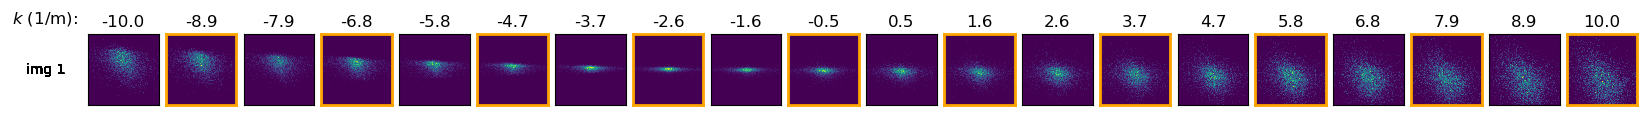

In [18]:
# plot generated datasets
fig, ax = plot_scan_data(train_dset, test_dset, bins, bins)
plt.show()

In [19]:
# training
pred_beam = train_1d_scan(train_dset, lattice, p0c, screen, n_epochs=2000, device='cuda')

Using device: cuda
0 tensor(4683934., device='cuda:0', grad_fn=<MulBackward0>)
100 tensor(1620013.3750, device='cuda:0', grad_fn=<MulBackward0>)
200 tensor(1595194., device='cuda:0', grad_fn=<MulBackward0>)
300 tensor(1600035.6250, device='cuda:0', grad_fn=<MulBackward0>)
400 tensor(1568629.6250, device='cuda:0', grad_fn=<MulBackward0>)
500 tensor(1560367.3750, device='cuda:0', grad_fn=<MulBackward0>)
600 tensor(1567949.8750, device='cuda:0', grad_fn=<MulBackward0>)
700 tensor(1575324.5000, device='cuda:0', grad_fn=<MulBackward0>)
800 tensor(1572807.6250, device='cuda:0', grad_fn=<MulBackward0>)
900 tensor(1591965.1250, device='cuda:0', grad_fn=<MulBackward0>)
1000 tensor(1578837.6250, device='cuda:0', grad_fn=<MulBackward0>)
1100 tensor(1567072.7500, device='cuda:0', grad_fn=<MulBackward0>)
1200 tensor(1561667.8750, device='cuda:0', grad_fn=<MulBackward0>)
1300 tensor(1581794.2500, device='cuda:0', grad_fn=<MulBackward0>)
1400 tensor(1584715.2500, device='cuda:0', grad_fn=<MulBackward

In [20]:
# predicted screens:
pred_dset = run_quad_scan(pred_beam, lattice, screen, ks)

image size = 80 x 80 mm
test samples boxed in orange


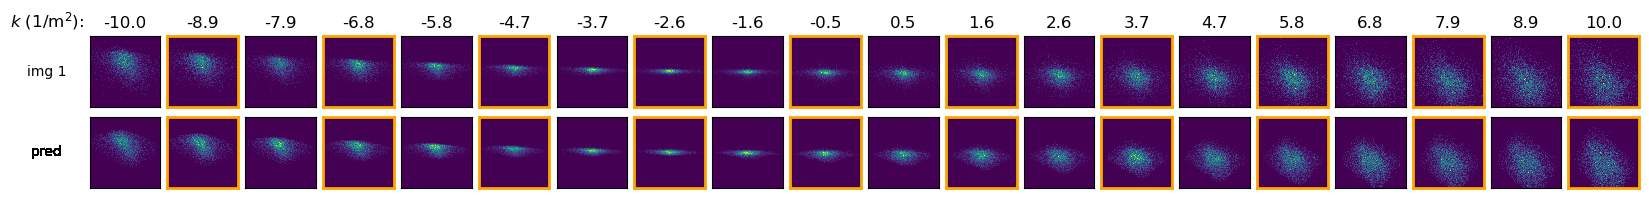

In [21]:
# compare predicted screens with data
fig, ax = plot_predicted_screens(pred_dset, train_dset, test_dset, bins, bins)
plt.show()

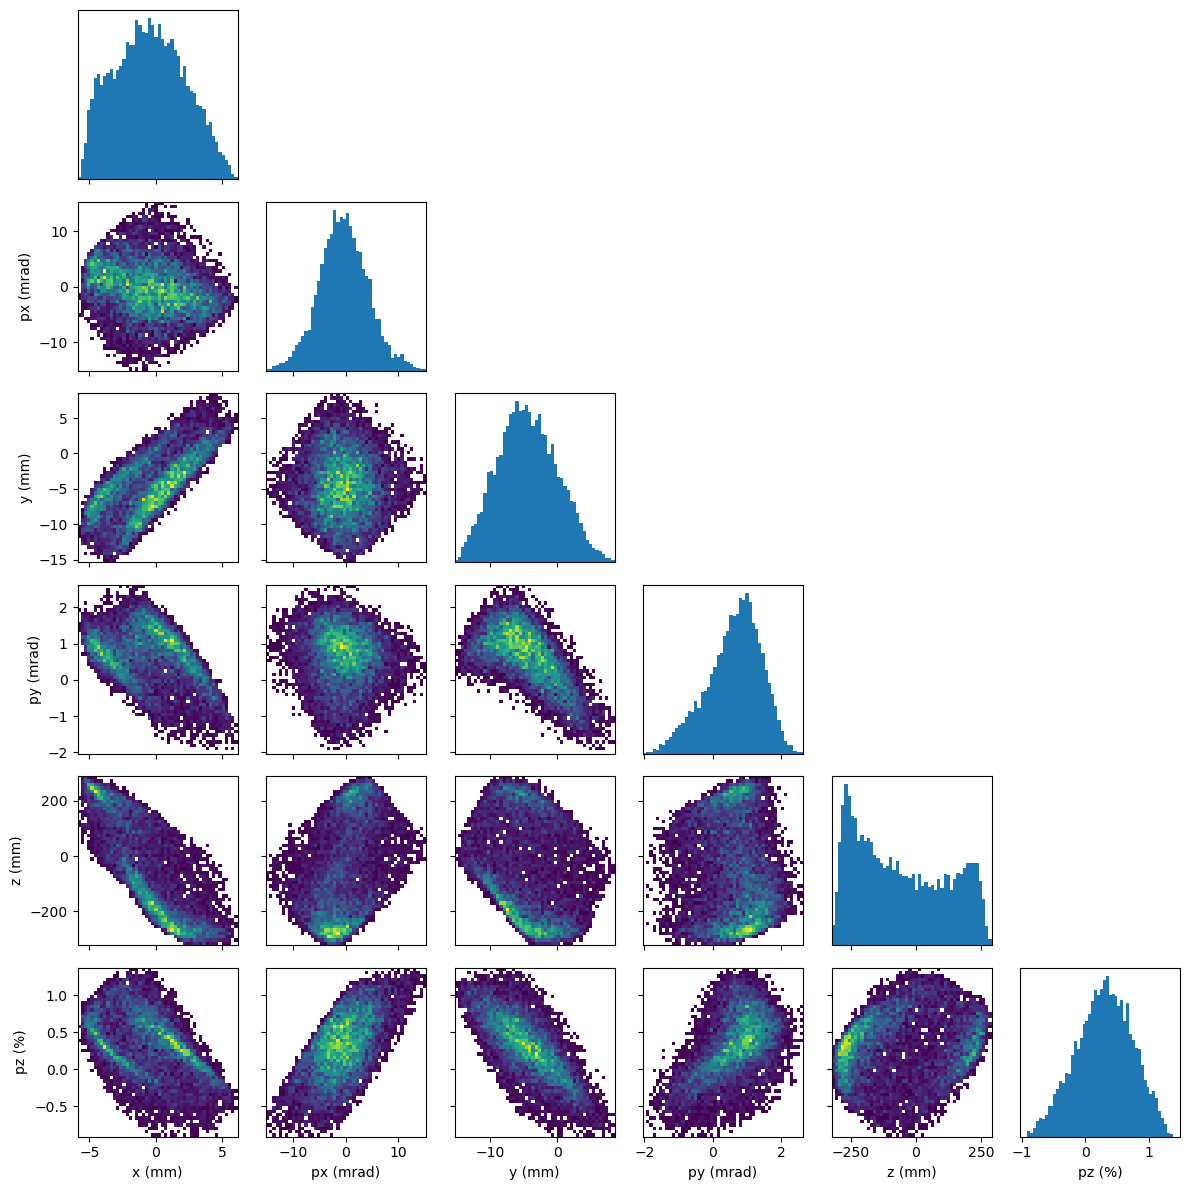

In [22]:
# reconstructed beam projections: 
fig, ax = plot_projections(pred_beam.numpy_particles()
                           )
plt.show()

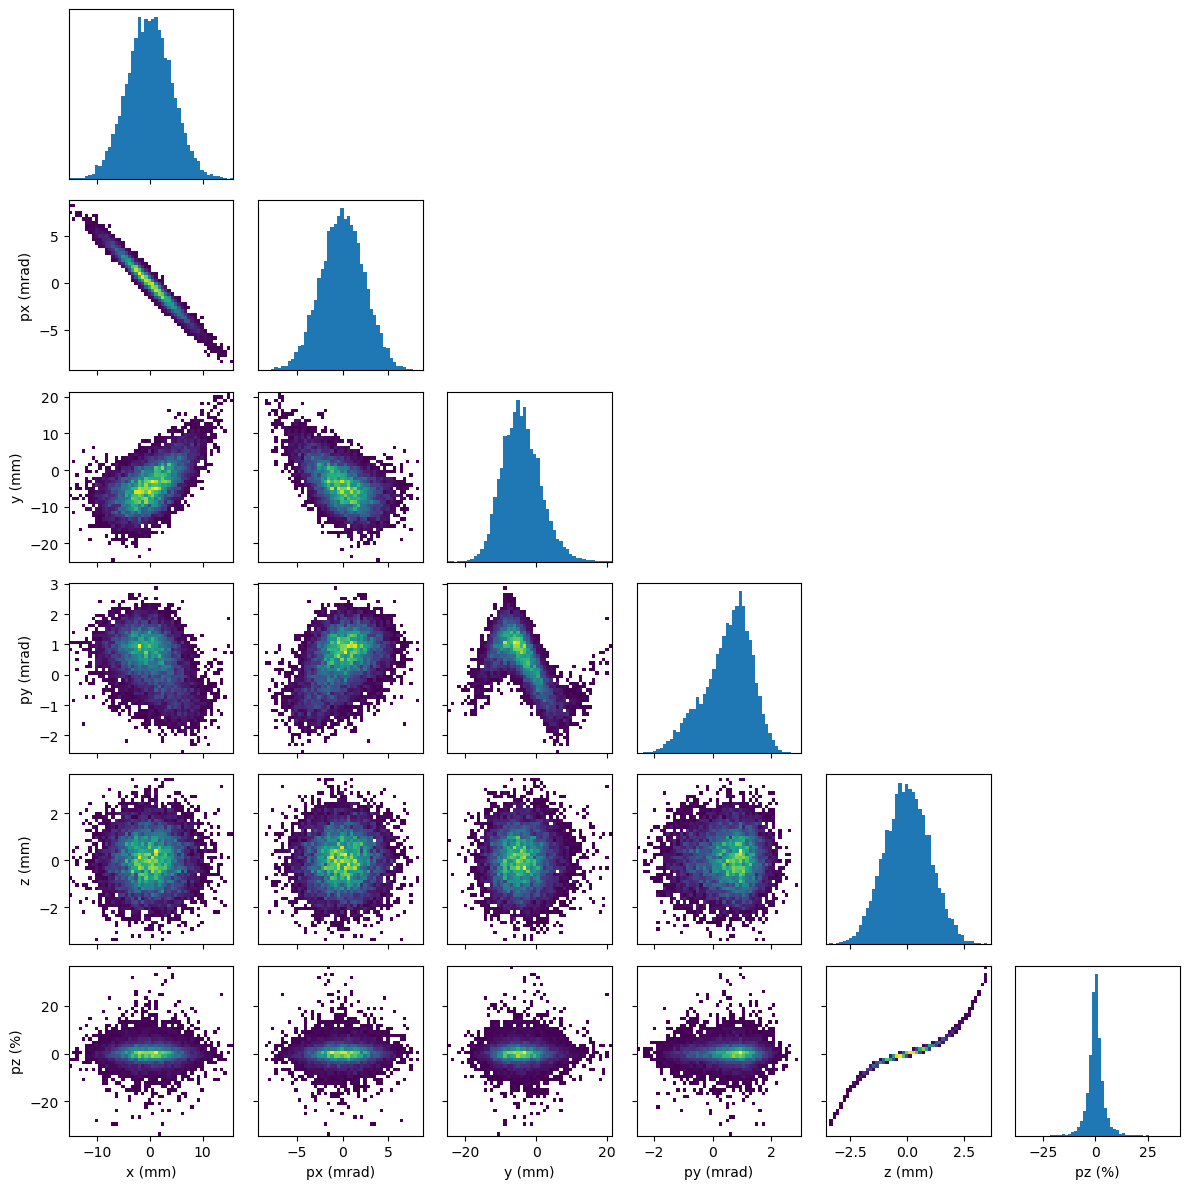

In [23]:
# ground truth beam projections:
fig, ax = plot_projections(gt_beam.numpy_particles())
plt.show()

In [24]:
torch.cuda.empty_cache()